In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

In [3]:
import numpy as np 
from tqdm import tqdm
import seaborn as sns
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras import layers, models
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.layers.core import Activation, Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras import backend as K

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications import ResNet101
from keras.applications import DenseNet201, DenseNet169, DenseNet121
from keras.applications import InceptionV3
from keras.applications import InceptionResNetV2
from keras.applications import Xception
from keras.applications import MobileNetV2
from keras.applications import MobileNet
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
import pandas as pd

from sklearn.svm import SVC

init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [4]:
def load_data(dir_path, img_size=(100, 100)):
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print('{} images loaded from {} directory.'.format(len(X), dir_path))
    return X, y, labels
    

In [5]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224, 224)

X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.58it/s]
C:\Users\zeyne\miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

564 images loaded from TRAIN/ directory.
68 images loaded from TEST/ directory.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.04it/s]

149 images loaded from VAL/ directory.


In [6]:
def preprocess_imgs(set_name, img_size):
    
    # Resize and apply VGG-15 preprocessing
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [7]:
X_train_prep = preprocess_imgs(set_name=X_train, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val, img_size=IMG_SIZE)

# CNN Pre-trained Models

## Data Augmentation

In [8]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=8,
    class_mode='binary',
    seed=RANDOM_SEED
)

validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=8,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 564 images belonging to 2 classes.
Found 149 images belonging to 2 classes.


In [9]:
# loading base model
def load_feature_extractor():
    base_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=IMG_SIZE + (3,))
    return base_model

In [10]:
model = load_feature_extractor()
#model.summary()

In [11]:
def extract_features(img_data):
    
    features = []
    for img in img_data:
        img = np.expand_dims(img, axis=0)
        feature = model.predict(img)
        feature_np = np.array(feature)
        features.append(feature_np.flatten())
    
    feature_list_np = np.array(features)
    
    return feature_list_np
        

In [12]:
X_train_ftr = extract_features(X_train_prep)
y_train_ftr = y_train
X_test_ftr = extract_features(X_test_prep)
y_test_ftr = y_test
X_val_ftr = extract_features(X_val_prep)
y_val_ftr = y_val

In [13]:
X_test_ftr.shape

(68, 51200)

### SVM

In [14]:
from sklearn.svm import SVC
classifier_SVM = SVC(kernel = 'rbf', random_state = 0)
classifier_SVM.fit(X_train_ftr, y_train_ftr)

SVC(random_state=0)

In [15]:
train_acc_SVM = classifier_SVM.score(X_train_ftr, y_train_ftr)
val_acc_SVM = classifier_SVM.score(X_val_ftr, y_val_ftr)
test_acc_SVM = classifier_SVM.score(X_test_ftr, y_test_ftr)

In [16]:
print(np.round(train_acc_SVM, 4))
print(np.round(val_acc_SVM, 4))
print(np.round(test_acc_SVM, 4))

0.883
0.8658
0.8676


In [17]:
y_pred_SVM = classifier_SVM.predict(X_test_ftr)

In [18]:
from sklearn import metrics
def print_performance_metrics(test_labels,predict):
    print('F1 Score:', np.round(metrics.f1_score(test_labels, predict,
                                               average='weighted'),4))
    print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(test_labels, predict),4))
    print('Recall:', np.round(metrics.recall_score(test_labels, predict,
                                               average='weighted'),4))
    print('Precision:', np.round(metrics.precision_score(test_labels, predict,average='weighted'),4))
    print('Accuracy:', np.round(metrics.accuracy_score(test_labels, predict),4))
    print('ROC Area:', np.round(metrics.roc_auc_score(test_labels, predict),4))
    print('Recall:', np.round(metrics.recall_score(test_labels, predict,
                                               average='weighted'),4))
    print('Matthews Corrcoef:', np.round(metrics.matthews_corrcoef(test_labels, predict),4)) 
    print('\t\tClassification Report:\n', metrics.classification_report(test_labels, predict))

print_performance_metrics(y_test,y_pred_SVM)

F1 Score: 0.8635
Cohen Kappa Score: 0.7161
Recall: 0.8676
Precision: 0.8803
Accuracy: 0.8676
ROC Area: 0.8446
Recall: 0.8676
Matthews Corrcoef: 0.7343
		Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.71      0.82        28
           1       0.83      0.97      0.90        40

    accuracy                           0.87        68
   macro avg       0.89      0.84      0.86        68
weighted avg       0.88      0.87      0.86        68



### RANDOM FOREST

In [19]:
from sklearn.ensemble import RandomForestClassifier
classifier_RF = RandomForestClassifier(n_estimators = 800, criterion = 'entropy',  random_state = 0)
classifier_RF.fit(X_train_ftr, y_train_ftr)

RandomForestClassifier(criterion='entropy', n_estimators=800, random_state=0)

In [20]:
train_acc_RF = classifier_RF.score(X_train_ftr, y_train_ftr)
print(np.round(train_acc_RF, 4))
val_acc_RF = classifier_RF.score(X_val_ftr, y_val_ftr)
print(np.round(val_acc_RF, 4))
test_acc_RF = classifier_RF.score(X_test_ftr, y_test_ftr)
print(np.round(test_acc_RF, 4))

1.0
0.9866
0.9853


In [21]:
y_pred_RF = classifier_RF.predict(X_test_ftr)
print_performance_metrics(y_test,y_pred_RF)

F1 Score: 0.9853
Cohen Kappa Score: 0.9695
Recall: 0.9853
Precision: 0.9857
Accuracy: 0.9853
ROC Area: 0.9821
Recall: 0.9853
Matthews Corrcoef: 0.9699
		Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        28
           1       0.98      1.00      0.99        40

    accuracy                           0.99        68
   macro avg       0.99      0.98      0.98        68
weighted avg       0.99      0.99      0.99        68



### ADABOOST

In [22]:
from sklearn.ensemble import AdaBoostClassifier
classifier_AB = AdaBoostClassifier(n_estimators = 100)
classifier_AB.fit(X_train_ftr, y_train_ftr)

AdaBoostClassifier(n_estimators=100)

In [23]:
train_acc_AB = classifier_AB.score(X_train_ftr, y_train_ftr)
print(train_acc_AB)
val_acc_AB = classifier_AB.score(X_val_ftr, y_val_ftr)
print(val_acc_AB)
test_acc_AB = classifier_AB.score(X_test_ftr, y_test_ftr)
print(test_acc_AB)

1.0
0.9798657718120806
0.9852941176470589


In [24]:
y_pred_AB = classifier_AB.predict(X_test_ftr)
print_performance_metrics(y_test,y_pred_AB)

F1 Score: 0.9853
Cohen Kappa Score: 0.9695
Recall: 0.9853
Precision: 0.9857
Accuracy: 0.9853
ROC Area: 0.9821
Recall: 0.9853
Matthews Corrcoef: 0.9699
		Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        28
           1       0.98      1.00      0.99        40

    accuracy                           0.99        68
   macro avg       0.99      0.98      0.98        68
weighted avg       0.99      0.99      0.99        68



### KNN

In [25]:
from sklearn.neighbors import KNeighborsClassifier
classifier_kNN = KNeighborsClassifier(n_neighbors = 5, algorithm='ball_tree', leaf_size=30)
classifier_kNN.fit(X_train_ftr, y_train_ftr)

KNeighborsClassifier(algorithm='ball_tree')

In [26]:
train_acc_kNN = classifier_kNN.score(X_train_ftr, y_train_ftr)
print(train_acc_kNN)
val_acc_kNN = classifier_kNN.score(X_val_ftr, y_val_ftr)
print(val_acc_kNN)
test_acc_kNN = classifier_kNN.score(X_test_ftr, y_test_ftr)
print(test_acc_kNN)

0.8102836879432624
0.8523489932885906
0.9264705882352942


In [27]:
y_pred_kNN = classifier_kNN.predict(X_test_ftr)
print_performance_metrics(y_test,y_pred_kNN)

F1 Score: 0.9267
Cohen Kappa Score: 0.849
Recall: 0.9265
Precision: 0.9272
Accuracy: 0.9265
ROC Area: 0.9268
Recall: 0.9265
Matthews Corrcoef: 0.8494
		Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.91        28
           1       0.95      0.93      0.94        40

    accuracy                           0.93        68
   macro avg       0.92      0.93      0.92        68
weighted avg       0.93      0.93      0.93        68



### XGBOOST

In [28]:
import xgboost as xgb
classifier_xgb = xgb.XGBClassifier(n_estimators = 300)
classifier_xgb.fit(X_train_ftr, y_train_ftr)

C:\Users\zeyne\miniconda3\envs\tensorflow\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[12:19:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [29]:
train_acc_xgb = classifier_xgb.score(X_train_ftr, y_train_ftr)
print(train_acc_xgb)
val_acc_xgb = classifier_xgb.score(X_val_ftr, y_val_ftr)
print(val_acc_xgb)
test_acc_xgb = classifier_xgb.score(X_test_ftr, y_test_ftr)
print(test_acc_xgb)

1.0
0.9865771812080537
0.9705882352941176


In [30]:
y_pred_xgb = classifier_xgb.predict(X_test_ftr)
print_performance_metrics(y_test,y_pred_xgb)

F1 Score: 0.9706
Cohen Kappa Score: 0.9393
Recall: 0.9706
Precision: 0.9706
Accuracy: 0.9706
ROC Area: 0.9696
Recall: 0.9706
Matthews Corrcoef: 0.9393
		Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96        28
           1       0.97      0.97      0.97        40

    accuracy                           0.97        68
   macro avg       0.97      0.97      0.97        68
weighted avg       0.97      0.97      0.97        68



### Confusion Matrices

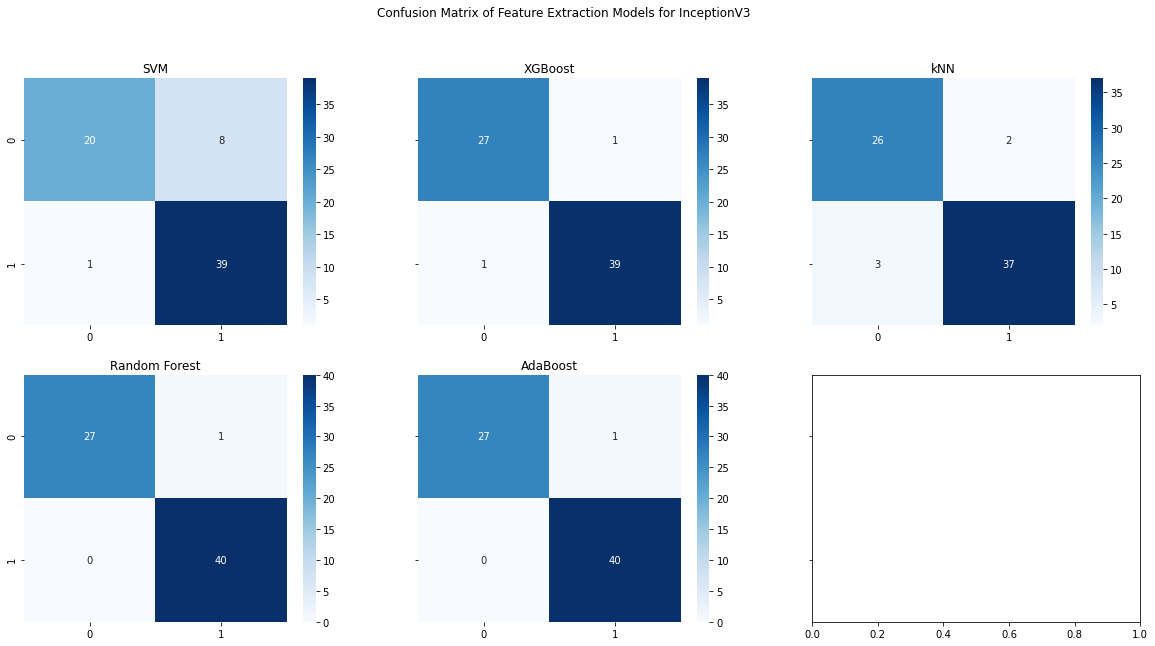

In [32]:
pred_index = {'SVM' : y_pred_SVM, 'AdaBoost' : y_pred_AB, 'kNN' : y_pred_kNN, 'Random Forest' : y_pred_RF, 'XGBoost' : y_pred_xgb}
fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharey=True, )
fig.suptitle('Confusion Matrix of Feature Extraction Models for InceptionV3')
for i, pred in enumerate(pred_index):
    sns.heatmap(confusion_matrix(y_test, pred_index[pred]),
                cmap='Blues', annot=True,ax=axes[i%2, i%3])
    axes[i%2, i%3].set_title(pred)